1. Tham khảo các bước

   Mô hình CNN: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

   Kĩ thuật deskew: https://stackoverflow.com/questions/43577665/deskew-mnist-images

   Dùng nội suy INTER_AREA VÌ: https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image

   Làm ảnh sắc nét hơn với phương pháp của người thứ 2: https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv

2. Dữ liệu đóng góp
  tổng cộng đóng góp 9 số từ 0->9 với mỗi số gồm 3 sample cho mỗi link:
  
      https://github.com/truong04/CS114.O21/tree/main/LAB01/data/22521575

      https://github.com/truong04/CS114.O21/tree/main/LAB01/data/22520125

      https://github.com/TruongSon421/CS114.O21/tree/main/LAB01/data/22521204

      https://github.com/TruongSon421/CS114.O21/tree/main/LAB01/data/22521260

      Tổng cộng là 120 mẫu




3. Đặc trưng và thuật toán học

   Sử dụng các lớp Convolutional Layers để trích xuất các đặc trưng của số như

   chi tiết thẳng đứng của số 1 hay nằm ngang của số 5

   Thêm các lớp drop out để tránh bị overfit với tập data MNIST

   MaxPooling giữ lại các đặc trưng quan trọng khi ảnh giảm kích thước ảnh
   
   Lớp dense kết hợp các đặc trưng lại và phân loại

In [1]:
import cv2
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import copy
import os
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
import os
local_zip = ('/content/drive/MyDrive/bao/cs114.o21.x.lab01-competition.zip')
zip_ref = ZipFile(local_zip,'r')
zip_ref.extractall('/content/test')
zip_ref.close()

In [4]:
from scipy.ndimage import affine_transform
from scipy.ndimage import interpolation

In [5]:
model = load_model('/content/drive/MyDrive/bao/model_6.h5')

In [6]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [ ]:
model = load_model('/content/drive/MyDrive/bao/fine_tune2.h5')

In [ ]:
model.summary()

In [ ]:
model = load_model('/content/drive/MyDrive/bao/fine_tune2.h5')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [ ]:
def prep_pixels(train):
  # convert from integers to floats
  train_norm = train.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0


  # return normalized images
  return train_norm

In [ ]:
import pandas as pd

path = pd.read_csv('/content/output_1101_1702.csv')
path.reset_index(drop=True, inplace=True)

In [ ]:
data_train = [f'/content/test/{i}'for i in path['data']]
label_train = [i for i in path['label']]

In [ ]:

def load_dataset1(train, label):
    # load dataset

    def preprocess(img):
        sharpen_kernel = np.array([[-1, -1, -1], [-1, 13, -1], [-1, -1, -1]])
        sharpen_img = cv2.filter2D(img, -1, sharpen_kernel)
        return sharpen_img

    def resize_image(image, new_width=None, new_height=None):
        img =cv2.imread(image)
        grayscaleImage = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        if new_width is None and new_height is None:
            return binaryImage
        resized_image = cv2.resize(binaryImage, (new_width, new_height), interpolation=cv2.INTER_AREA)
        return preprocess(resized_image)

    def resize_images_in_dataset(images, new_width=None, new_height=None):
        resized_images = list(map(lambda x: resize_image(x, new_width, new_height), images))
        return np.array(resized_images)

    # reshape dataset to have a single channel
    new_train = resize_images_in_dataset(train, 28, 28)

    # reshape dataset to have a single channel
    x = new_train.reshape((new_train.shape[0], 28, 28, 1))

    # one hot encode target values
    y = to_categorical(label)

    return x,y

In [ ]:
data_train1,label_train1 = load_dataset1(data_train,label_train)

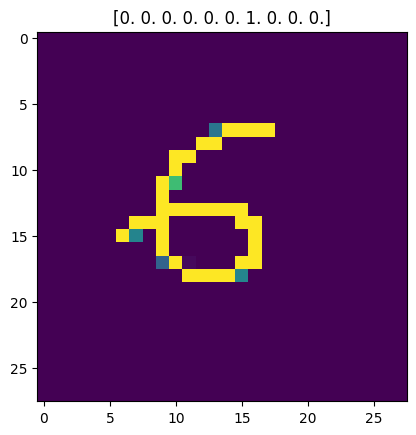

In [ ]:
plt.imshow(data_train1[0])
plt.title(f'{label_train1[0]}')
plt.show()

In [ ]:
from tensorflow import keras

callback = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=15,
        restore_best_weights=True,
        verbose=1)
]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY,model):
  scores, histories = list(), list()


  # select rows for train and test
  trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size = 0.3, random_state =30)

  # fit model
  history = model.fit(trainX, trainY, epochs=15, batch_size=32, validation_data=(testX, testY),callbacks = [callback])

  # evaluate model
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # stores scores
  scores.append(acc)
  histories.append(history)

  return scores, histories,model

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [ ]:
def run_test_harness(model):
  # load dataset
  trainX, trainY= load_dataset1(data_train,label_train)

  # prepare pixel data
  trainX =prep_pixels(trainX)

  # evaluate model
  scores, histories,model = evaluate_model(trainX, trainY,model)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)


  model.save('/content/drive/MyDrive/bao/fine_tune3.h5')

Epoch 1/15
13/13 [==============================] - 4s 228ms/step - loss: 0.6158 - accuracy: 0.8627 - val_loss: 0.7454 - val_accuracy: 0.8258
Epoch 2/15
13/13 [==============================] - 2s 186ms/step - loss: 0.3381 - accuracy: 0.8843 - val_loss: 0.5546 - val_accuracy: 0.8202
Epoch 3/15
13/13 [==============================] - 3s 268ms/step - loss: 0.2649 - accuracy: 0.9036 - val_loss: 0.5718 - val_accuracy: 0.8146
Epoch 4/15
13/13 [==============================] - 5s 364ms/step - loss: 0.2320 - accuracy: 0.9253 - val_loss: 0.5373 - val_accuracy: 0.8202
Epoch 5/15
13/13 [==============================] - 4s 323ms/step - loss: 0.1700 - accuracy: 0.9422 - val_loss: 0.5909 - val_accuracy: 0.8146
Epoch 6/15
13/13 [==============================] - 2s 187ms/step - loss: 0.1121 - accuracy: 0.9735 - val_loss: 0.6499 - val_accuracy: 0.8034
Epoch 7/15
13/13 [==============================] - 2s 193ms/step - loss: 0.0997 - accuracy: 0.9639 - val_loss: 0.6575 - val_accuracy: 0.8202
Epoch 

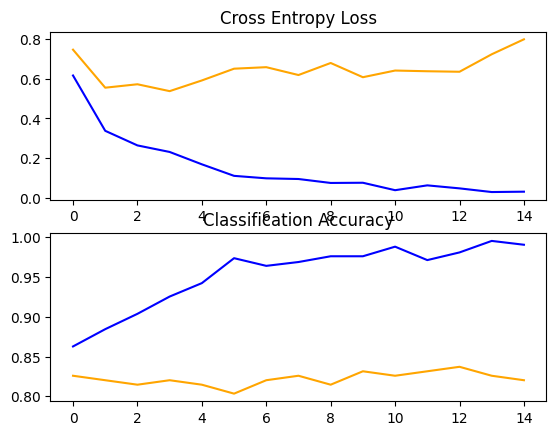

Accuracy: mean=82.022 std=0.000, n=1


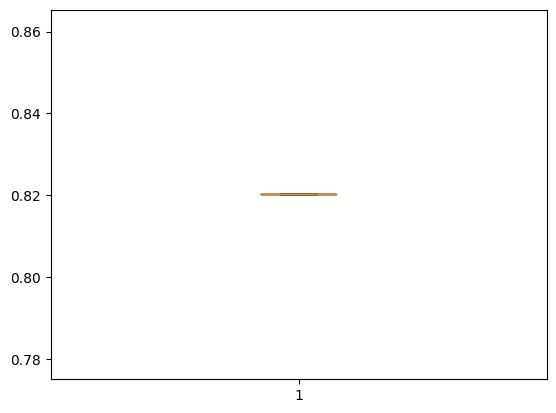

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# entry point, run the test harness
run_test_harness(model)

In [ ]:
model = load_model('/content/drive/MyDrive/bao/fine_tune3.h5')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [ ]:
def moments(image):
    c0, c1 = np.mgrid[:image.shape[0], :image.shape[1]]
    totalImage = np.sum(image)  # sum of pixels
    m0 = np.sum(c0 * image) / totalImage
    m1 = np.sum(c1 * image) / totalImage
    m00 = np.sum((c0 - m0) ** 2 * image) / totalImage
    m11 = np.sum((c1 - m1) ** 2 * image) / totalImage
    m01 = np.sum((c0 - m0) * (c1 - m1) * image) / totalImage
    mu_vector = np.array([m0, m1])
    covariance_matrix = np.array([[m00, m01], [m01, m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    c, v = moments(image)
    alpha = v[0, 1] / v[0, 0]
    affine = np.array([[1, 0], [alpha, 1]])
    ocenter = np.array(image.shape) / 2.0
    offset = c - np.dot(affine, ocenter)
    return affine_transform(image, affine, offset=offset)


In [ ]:
def run_example(path,visualize = True):
  try:
        image = cv2.imread(path)
        if visualize:
          plt.imshow(image)
          plt.title('filter')
          plt.show()
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        value = 35
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
        final_hsv = cv2.merge((h, s, v))
        img_resize = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        inputImageCopy = img_resize.copy()
        grayscaleImage = cv2.cvtColor(inputImageCopy, cv2.COLOR_BGR2GRAY)
        threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        img_resize1 = deskew(binaryImage)

        gray = cv2.resize(img_resize1, (28, 28), interpolation=cv2.INTER_AREA)

        sharpen_kernel = np.array([[-1,-1,-1], [-1,13,-1], [-1,-1,-1]])

        sharpen_img = cv2.filter2D(gray, -1, sharpen_kernel)
        if visualize:
          plt.imshow(sharpen_img)
          plt.title('filter')
          plt.show()
        sharpen_img = sharpen_img.astype('float32')
        sharpen_img = sharpen_img / 255.0


        #Hiển thị ảnh kết quả
        image_file = np.array(sharpen_img)
        prediction = model.predict(image_file.reshape(1, 28, 28, 1))
        digit = argmax(prediction)
        return digit
  except:
    return 0

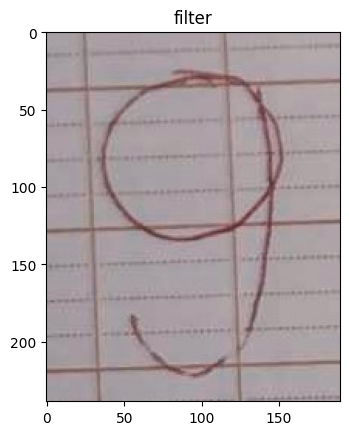

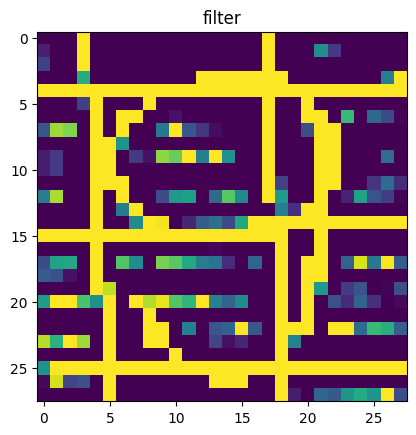

1/1 [==============================] - 0s 132ms/step


9

In [ ]:
path = "/content/test/000caf706334cf9598988fbf3e103a0c  -.jpg"
run_example(path)

In [ ]:
results = []
org_dir = "/content/test"

for item in os.listdir(org_dir):
    dir1 = os.path.join(org_dir, item)
    digit = run_example(dir1,False)
    results.append([item, digit])

1/1 [==============================] - 0s 34ms/step


In [ ]:
len(results)

2939

In [ ]:
import pandas as pd


# Chuyển danh sách kết quả thành DataFrame
df = pd.DataFrame(results, columns=['file_name', 'label'])

# Lưu DataFrame thành file CSV
df.to_csv('fine_tunning.csv', index=False, header=False)